In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage
import skimage.io as io
import cv2

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, "Mask_RCNN"))  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import carplate

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

CARPLATE_WEIGHTS_PATH = "mask_rcnn_carplate_0030.h5"

Using TensorFlow backend.


# 载入车牌定位模型

In [2]:
config = carplate.CarplateConfig()
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()

DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

TEST_MODE = "inference"

In [3]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [4]:
# Load weights
weights_path = CARPLATE_WEIGHTS_PATH
print("Loading weights", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights mask_rcnn_carplate_0030.h5


# 载入车牌字符识别模型

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [6]:
vocabulary = ["京", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "皖", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
"琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A",
"B", "C", "D", "E", "F", "G", "H", "J", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "U", "V", "W", "X",
"Y", "Z","港","学","使","警","澳","挂","军","北","南","广","沈","兰","成","济","海","民","航","空", ""]

In [18]:
class Model(nn.Module):
    
    '''
    [1, 3, 160, 40]
    [1, 32, 80, 20]
    [1, 64, 40, 10]
    [1, 128, 20, 5]
    [1, 256, 20, 1]

    [1, 1024, 20, 1]
    [1, 1024, 20, 1]

    [1, 84, 20, 1]
    [1, 84, 20, 1]
    '''
    
    def __init__(self):
        super().__init__()
        
        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=1)
        self.bn0 = nn.BatchNorm2d(32)
        self.relu0 = nn.ReLU()
        self.pool0 = nn.MaxPool2d(2, stride=2)
        
        self.conv1 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, stride=2)
        
        self.conv2d_1 = nn.Conv2d(128, 256, (1,5), stride=1)
        self.batch_normalization_1 = nn.BatchNorm2d(256)
        self.activation_1 = nn.ReLU()
        
        # --------------------
        
        self.conv2d_2 = nn.Conv2d(256, 256, (7,1), stride=1, padding=(3,0))
        self.batch_normalization_2 = nn.BatchNorm2d(256)
        self.activation_2 = nn.ReLU()
        
        self.conv2d_3 = nn.Conv2d(256, 256, (5,1), stride=1, padding=(2,0))
        self.batch_normalization_3 = nn.BatchNorm2d(256)
        self.activation_3 = nn.ReLU()
        
        self.conv2d_4 = nn.Conv2d(256, 256, (3,1), stride=1, padding=(1,0))
        self.batch_normalization_4 = nn.BatchNorm2d(256)
        self.activation_4 = nn.ReLU()
        
        self.conv2d_5 = nn.Conv2d(256, 256, (1,1), stride=1)
        self.batch_normalization_5 = nn.BatchNorm2d(256)
        self.activation_5 = nn.ReLU()
        
        # -----------------
        
        self.conv_1024_11 = nn.Conv2d(1024, 1024, 1, stride=1)
        self.batch_normalization_6 = nn.BatchNorm2d(1024)
        self.activation_6 = nn.ReLU()
        
        self.conv_class_11 = nn.Conv2d(1024, 84, 1, stride=1)
        
        # ------------------------------------------
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(256*20*1, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
    def stn(self, x):
        #xs = self.localization(x)
        xs = x
        xs = xs.view(-1, 256*20*1)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x
        
    def forward(self, x):
        x = self.pool0(self.relu0(self.bn0(self.conv0(x))))
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.activation_1(self.batch_normalization_1(self.conv2d_1(x)))
        
        # stn
        #x = self.stn(x)
        
        x2 = self.activation_2(self.batch_normalization_2(self.conv2d_2(x)))
        x3 = self.activation_3(self.batch_normalization_3(self.conv2d_3(x)))
        x4 = self.activation_4(self.batch_normalization_4(self.conv2d_4(x)))
        x5 = self.activation_5(self.batch_normalization_5(self.conv2d_5(x)))
        
        x = torch.cat([x2, x3, x4, x5], dim=1)
        
        x = self.activation_6(self.batch_normalization_6(self.conv_1024_11(x)))
        x = self.conv_class_11(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [19]:
def remove_connective_duplicate(src):
    last = None
    out = []
    for c in src.tolist():
        if last is None or last != c:
            last = c
            out.append(c)
    
    return np.array(out)

def decode(output):
    return ''.join(list(map(lambda i: vocabulary[i], output)))

def decode_prob(prob):
    return decode(remove_connective_duplicate(prob.argmax(axis=0)))

In [47]:
#model_recognition = torch.load('model-lastest.pth',map_location='cpu')
model_recognition = Model().cuda()
model_recognition = torch.load('../simple-car-plate-recognition-2/model-lastest.pth')
model_recognition = model_recognition.eval()

In [22]:
def recognize(image):
    image = cv2.resize(image, (160,40)).transpose((2,1,0))
    output = model_recognition(torch.tensor(image[np.newaxis,...]).float().cuda())[0].squeeze().detach().cpu().numpy()
    return decode_prob(output)

# 载入图片

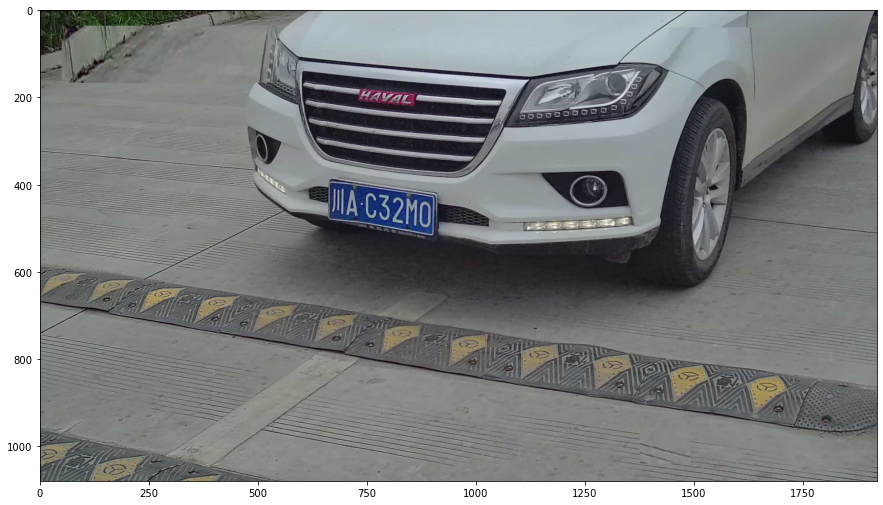

In [40]:
image = io.imread('car2.jpg')

plt.figure(figsize=(15,10))
plt.imshow(image)

In [41]:
%%time

results = model.detect([image], verbose=0)
r = results[0]

Wall time: 1.15 s


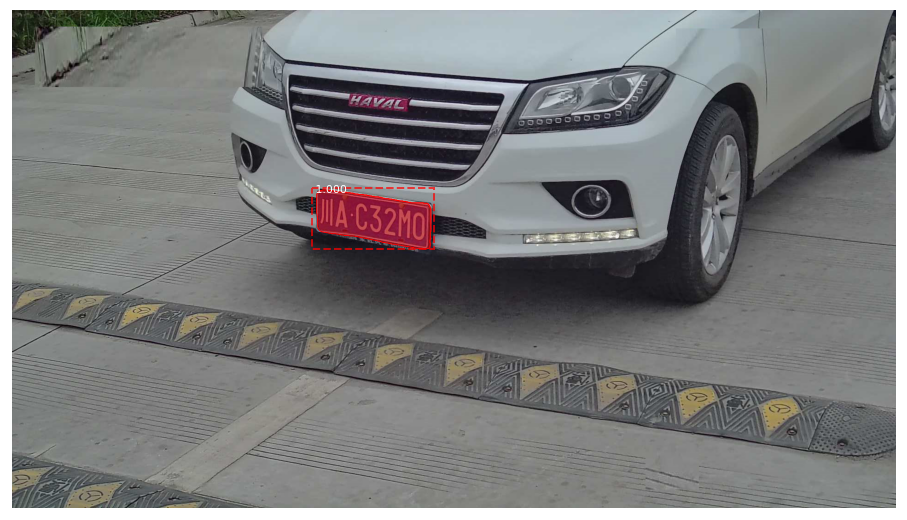

In [42]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax
ax = get_ax(1)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], ['',''], r['scores'], ax=ax)

# 定位车牌

In [43]:
def point_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 )

def shortest_point(p1, arr):
    min_distance = None
    min_p2 = None
    for p2 in arr:
        distance = point_distance(p1, p2)
        if min_distance == None:
            min_distance = distance
        elif min_distance > distance:
            min_distance = distance
            min_p2 = p2
    return min_p2

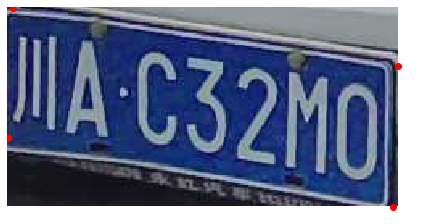

In [44]:
# 1.提取车牌区域，只取第一个车牌
mask = r['masks'][:,:,0].astype(np.uint8)

contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
cnt = contours[0]

epsilon = 0.1 * cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt, epsilon, True)
approx = approx.squeeze()

#if approx.shape == (4,2):
#    box = np.zeros_like(approx)
#    box[:, 1] = approx[:, 1]
#    box[:, 0] = approx[:, 0]
#else:
#    rect = cv2.minAreaRect(cnt)
#    box = cv2.boxPoints(rect).astype(np.int)

rect = cv2.minAreaRect(cnt)
box = cv2.boxPoints(rect).astype(np.int)
box = np.array([shortest_point(p1, cnt.squeeze()) for p1 in box])

x0, y0 = box.min(axis=0)
x1, y1 = box.max(axis=0)
img = image[y0:y1, x0:x1]
plt.axis('off')
io.imshow(img)

box[:, 0] -= x0
box[:, 1] -= y0

# 调整box顺序
i0 = (box[:,0]+box[:,1]).argmin()
box = box[[i0,(i0+1)%4,(i0+2)%4,(i0+3)%4]]

plt.scatter(box[:, 0], box[:, 1], c='r')

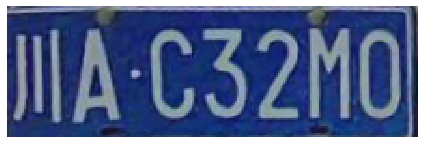

In [45]:
# 2.矫正车牌
w = np.max([box[1][0] - box[0][0], box[2][0] - box[3][0]])
h = np.max([box[2][1] - box[1][1], box[3][1] - box[0][1]])
box2 = np.array([(0, 0), (w, 0), (w, h), (0, h)])

M = cv2.getPerspectiveTransform(box[:,::].astype(np.float32), box2[:,::].astype(np.float32))
img2 = cv2.warpPerspective(img, M, (w, h))
img2 = cv2.resize(img2, (220, 70))

plt.axis('off')
io.imshow(img2)

# 识别字符

In [48]:
%%time

cv2.imwrite('../simple-car-plate-recognition-2/test.jpg', img2[:,:,::-1])
recognize(img2)

Wall time: 5.02 ms


'川AC32M0'